Caricamento dataset e prima visualizzazione

In [3]:
import pandas as pd

RAW_PATH = "../../datasets/gz_recipe.csv"

recipes = pd.read_csv(RAW_PATH)

print(recipes.head())
print(recipes.info())
print(recipes.describe())


   Unnamed: 0                                 Nome Categoria  \
0           0                             Tiramisù     Dolci   
1           1                              Cookies     Dolci   
2           2        Pancake allo sciroppo d'acero     Dolci   
3           3                  Crema al mascarpone     Dolci   
4           4  Crepe dolci e salate (ricetta base)     Dolci   

                                                Link  Persone/Pezzi  \
0   https://ricette.giallozafferano.it/Tiramisu.html              8   
1    https://ricette.giallozafferano.it/Cookies.html             12   
2  https://ricette.giallozafferano.it/Pancakes-al...              4   
3  https://ricette.giallozafferano.it/Crema-al-ma...              4   
4  https://ricette.giallozafferano.it/Crepes-dolc...             15   

                                         Ingredienti  \
0  [['Mascarpone', '750g'], ['Uova', '260g'], ['S...   
1  [['Farina 00', '195g'], ['Burro', '100g'], ['B...   
2  [['Burro', '25g']

Rimozioni dati nulli

In [5]:
# 1. Rimuoviamo righe con valori nulli nelle colonne critiche
# Se manca il Titolo, gli Ingredienti o gli Step, la ricetta è inutile per il bot
recipes.dropna(subset=['Nome', 'Ingredienti', 'Steps'], inplace=True)
print(recipes.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5935 entries, 0 to 5938
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     5935 non-null   int64 
 1   Nome           5935 non-null   object
 2   Categoria      5933 non-null   object
 3   Link           5935 non-null   object
 4   Persone/Pezzi  5935 non-null   int64 
 5   Ingredienti    5935 non-null   object
 6   Steps          5935 non-null   object
dtypes: int64(2), object(5)
memory usage: 370.9+ KB
None


Normalizzazione nomi e categorie

In [6]:
recipes["Nome"] = recipes["Nome"].str.strip().str.lower()
recipes["Categoria"] = recipes["Categoria"].str.strip().str.lower()

Creazione lista di dizionari per gli ingredienti

In [7]:
import ast

def parse_ingredients(x):
    try:
        parsed = ast.literal_eval(x)
        return [
            {
                "nome": ing[0].strip().lower(),
                "quantita": ing[1].strip().lower()
            }
            for ing in parsed
        ]
    except:
        return []

recipes["ingredienti_parsed"] = recipes["Ingredienti"].apply(parse_ingredients)

Creazione nuova colonna "ingredienti_flat" per facilitare la ricerca

In [8]:
recipes["ingredienti_flat"] = recipes["ingredienti_parsed"].apply(
    lambda x: [i["nome"] for i in x]
)

Pulizia testo preparazione

In [10]:
recipes["Steps"] = (
    recipes["Steps"]
    .str.replace("\n", " ")
    .str.strip()
)

Pulizia eventuali dati sporchi di "persone/pezzi"

In [11]:
recipes = recipes[recipes['Persone/Pezzi'] > 0]

Nuova colonna per la stima della difficoltà

In [14]:
def stima_difficolta(row):
    n_ing = len(row["ingredienti_flat"])

    if n_ing <= 6:
        return "facile"
    elif n_ing <= 10:
        return "media"
    else:
        return "difficile"

recipes["difficolta"] = recipes.apply(stima_difficolta, axis=1)

print(recipes["difficolta"].value_counts())

difficolta
difficile    2861
media        2317
facile        757
Name: count, dtype: int64


EDA

In [15]:
print("Numero ricette:", len(recipes))
print("\nCategorie disponibili:")
print(recipes["Categoria"].value_counts())

print("\nNumero medio ingredienti per ricetta:")
print(recipes["ingredienti_flat"].apply(len).mean())

Numero ricette: 5935

Categorie disponibili:
Categoria
dolci                    1742
primi piatti             1313
antipasti                 887
secondi piatti            830
lievitati                 329
piatti unici              271
contorni                  175
torte salate              105
salse e sughi              91
bevande                    71
marmellate e conserve      62
insalate                   57
Name: count, dtype: int64

Numero medio ingredienti per ricetta:
10.96781802864364


Import e stile

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Impostazioni grafiche per renderli più leggibili
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

Analisi delle categorie

C:\Users\risol\AppData\Local\Temp\ipykernel_11024\3971944309.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Categoria', data=recipes, order=order, palette='viridis')


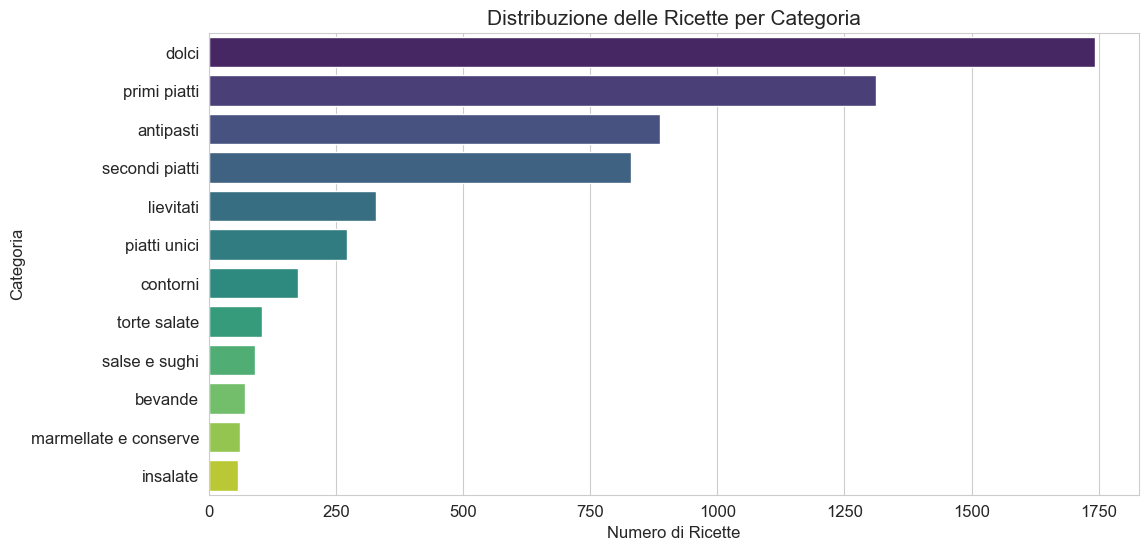

In [17]:
# 1. Distribuzione delle Categorie
plt.figure(figsize=(12, 6))
order = recipes['Categoria'].value_counts().index
sns.countplot(y='Categoria', data=recipes, order=order, palette='viridis')
plt.title('Distribuzione delle Ricette per Categoria', fontsize=15)
plt.xlabel('Numero di Ricette')
plt.ylabel('Categoria')
plt.show()

Analisi difficoltà

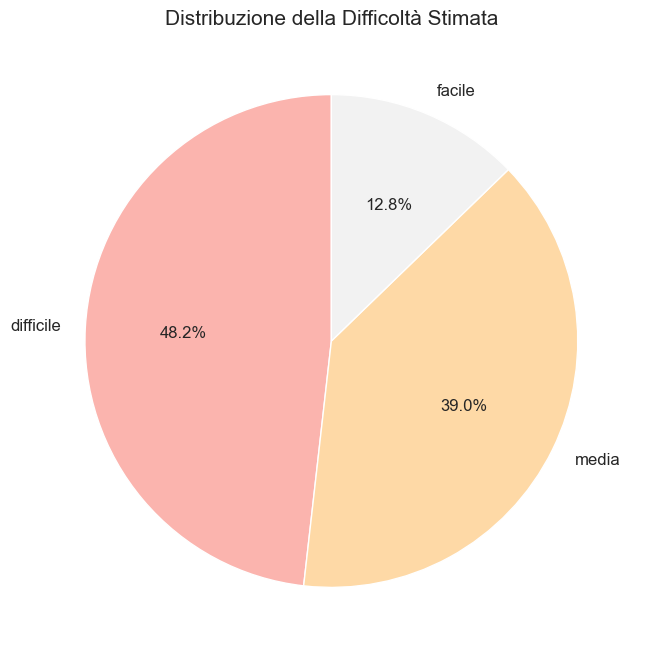

<Figure size 1200x600 with 0 Axes>

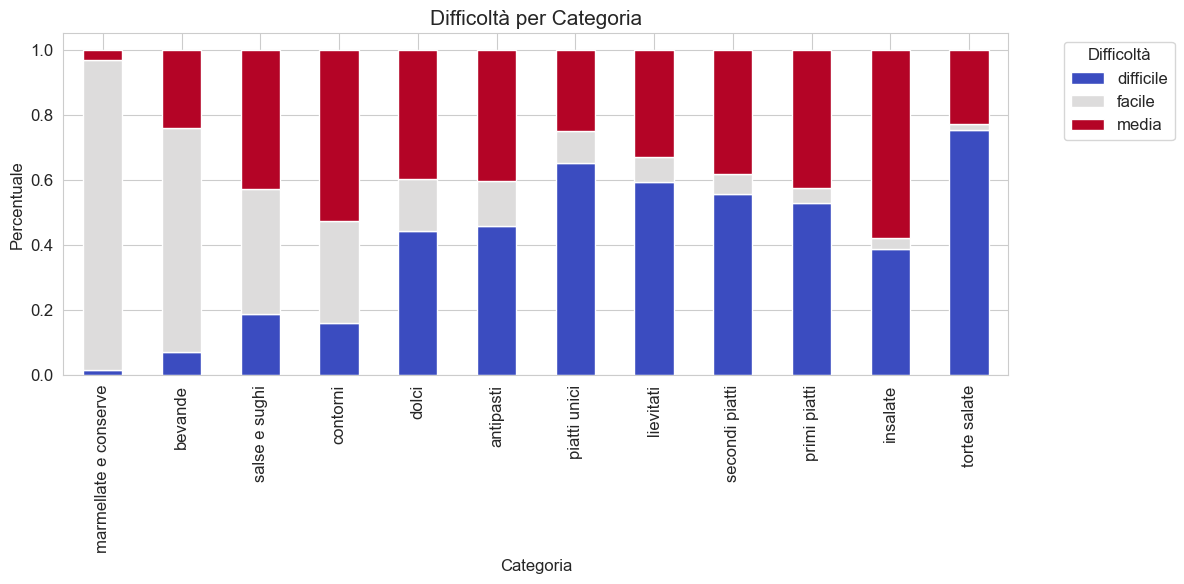

In [18]:
# 2. Distribuzione della Difficoltà (Pie Chart)
plt.figure(figsize=(8, 8))
recipes['difficolta'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Pastel1', ylabel='')
plt.title('Distribuzione della Difficoltà Stimata', fontsize=15)
plt.show()

# 3. Relazione Categoria vs Difficoltà
# Vediamo se i dolci sono più difficili degli antipasti
plt.figure(figsize=(12, 6))
# Creiamo una tabella incrociata normalizzata per vedere le percentuali
ct = pd.crosstab(recipes['Categoria'], recipes['difficolta'], normalize='index')
# Ordiniamo per leggibilità (es. in base a quanto sono "facili")
ct = ct.sort_values('facile', ascending=False)
ct.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(12,6))
plt.title('Difficoltà per Categoria', fontsize=15)
plt.ylabel('Percentuale')
plt.legend(title='Difficoltà', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Analisi degli ingredienti

C:\Users\risol\AppData\Local\Temp\ipykernel_11024\76966378.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequenza', y='Ingrediente', data=df_top_ing, palette='magma')


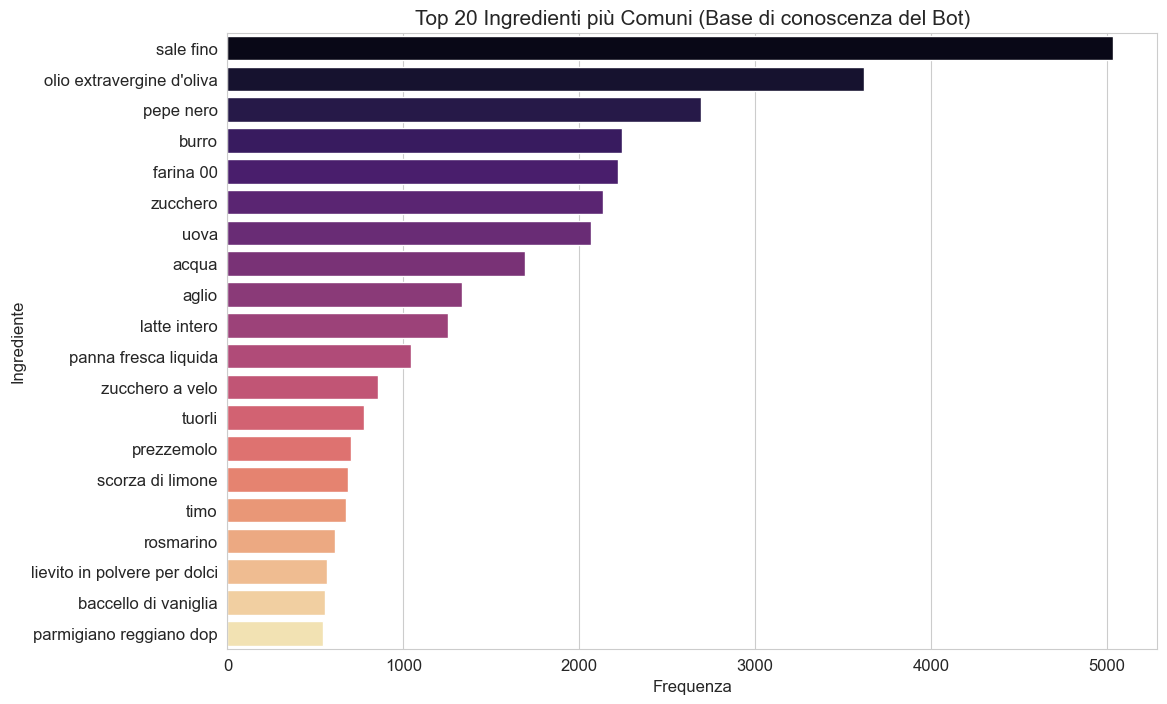

In [19]:
# 4. Top 20 Ingredienti più usati
# Appiattiamo la lista di liste 'ingredienti_flat' in una lista unica enorme
all_ingredients = [ing for sublist in recipes['ingredienti_flat'] for ing in sublist]
top_20 = Counter(all_ingredients).most_common(20)

# Creiamo un DataFrame al volo per il grafico
df_top_ing = pd.DataFrame(top_20, columns=['Ingrediente', 'Frequenza'])

plt.figure(figsize=(12, 8))
sns.barplot(x='Frequenza', y='Ingrediente', data=df_top_ing, palette='magma')
plt.title('Top 20 Ingredienti più Comuni (Base di conoscenza del Bot)', fontsize=15)
plt.show()

Distribuzione quantitativa (ingredienti e persone)

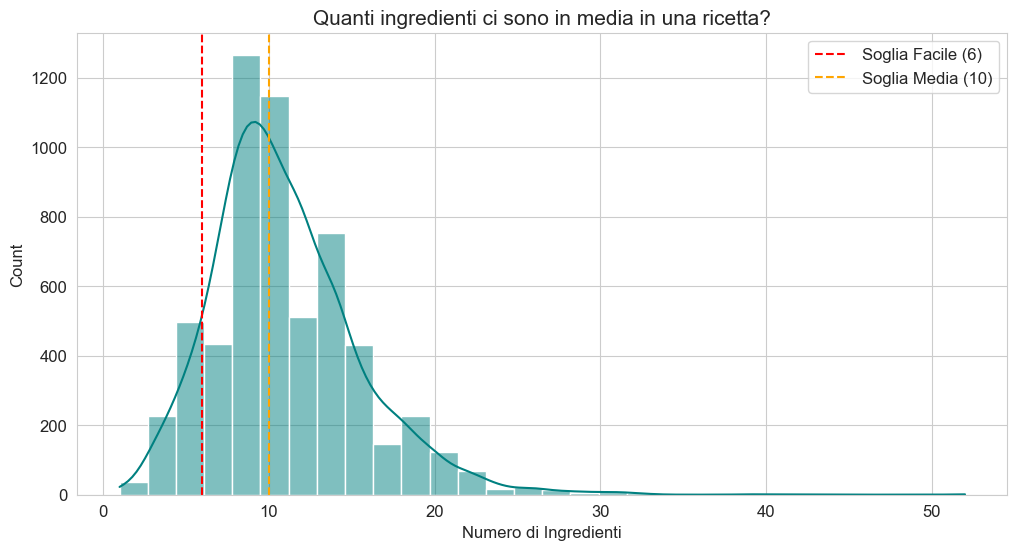

In [20]:
# 5. Distribuzione del Numero di Ingredienti per Ricetta
# Calcoliamo la lunghezza delle liste ingredienti
recipes['num_ingredienti'] = recipes['ingredienti_flat'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(recipes['num_ingredienti'], bins=30, kde=True, color='teal')
plt.axvline(x=6, color='r', linestyle='--', label='Soglia Facile (6)')
plt.axvline(x=10, color='orange', linestyle='--', label='Soglia Media (10)')
plt.title('Quanti ingredienti ci sono in media in una ricetta?', fontsize=15)
plt.xlabel('Numero di Ingredienti')
plt.legend()
plt.show()

Analisi della difficoltà

C:\Users\risol\AppData\Local\Temp\ipykernel_11024\2326362580.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


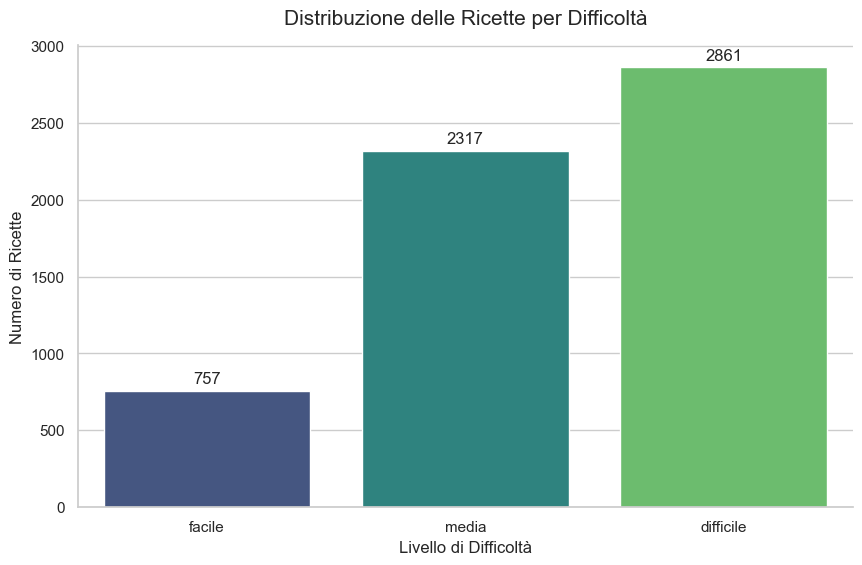

C:\Users\risol\AppData\Local\Temp\ipykernel_11024\2326362580.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


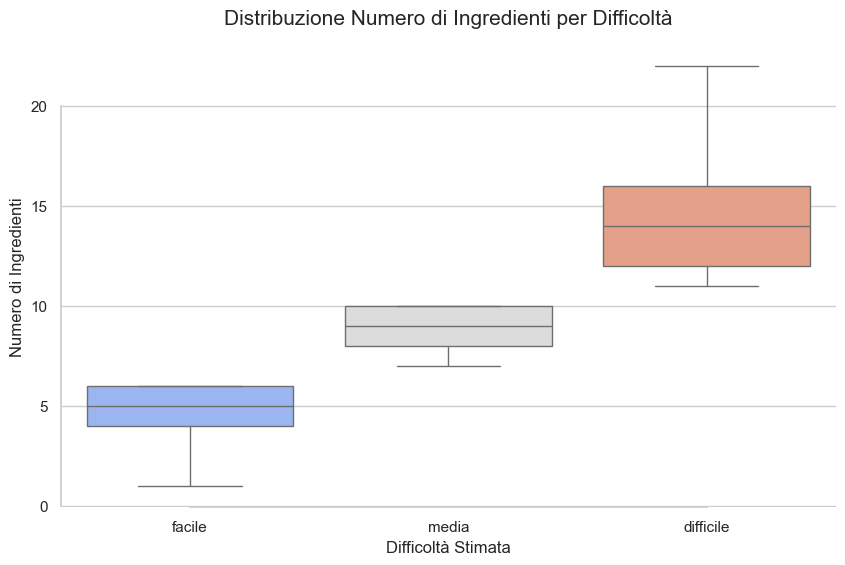

C:\Users\risol\AppData\Local\Temp\ipykernel_11024\2326362580.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


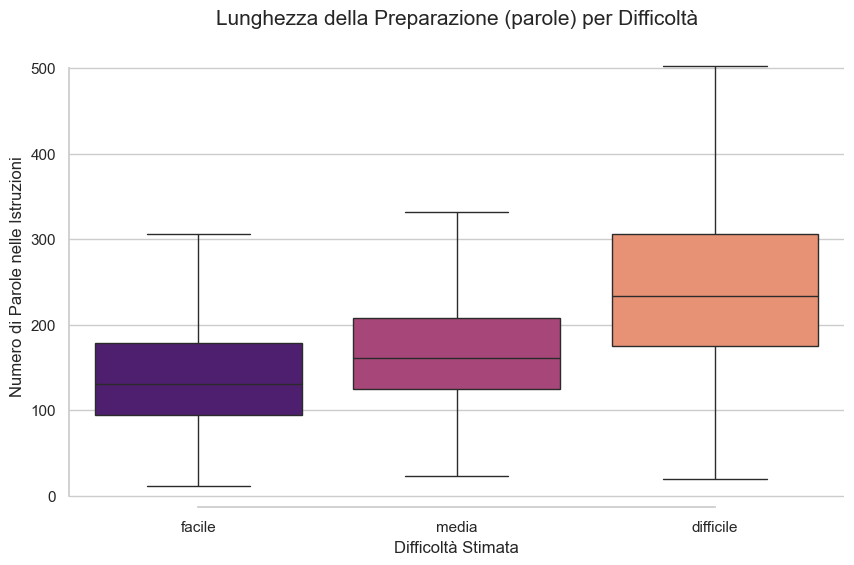

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Impostiamo lo stile grafico generale
sns.set_theme(style="whitegrid", palette="pastel")
plt.rcParams['figure.figsize'] = (10, 6)

# Definiamo un ordine logico per le categorie (altrimenti le mette in ordine alfabetico)
order_diff = ['facile', 'media', 'difficile']

# -------------------------------------------------------
# 1. GRAFICO A BARRE: Distribuzione della difficoltà
# -------------------------------------------------------
plt.figure()
ax = sns.countplot(
    x='difficolta', 
    data=recipes, 
    order=order_diff,
    palette='viridis'
)
plt.title("Distribuzione delle Ricette per Difficoltà", fontsize=15, pad=15)
plt.xlabel("Livello di Difficoltà")
plt.ylabel("Numero di Ricette")

# --- FIX: Ciclo su tutti i container per essere sicuri di etichettare tutto ---
for container in ax.containers:
    ax.bar_label(container, padding=3) 

sns.despine()
plt.show()

# -------------------------------------------------------
# 2. BOXPLOT: Numero di Ingredienti per Difficoltà
# -------------------------------------------------------
# Calcoliamo la lunghezza al volo senza salvare la colonna nel df
n_ing_temp = recipes['ingredienti_flat'].apply(len)

plt.figure()
sns.boxplot(
    x=recipes['difficolta'], 
    y=n_ing_temp, 
    order=order_diff,
    palette="coolwarm",
    showfliers=False # Nasconde gli outlier estremi per rendere il grafico più leggibile
)
plt.title("Distribuzione Numero di Ingredienti per Difficoltà", fontsize=15, pad=15)
plt.xlabel("Difficoltà Stimata", fontsize=12)
plt.ylabel("Numero di Ingredienti", fontsize=12)
sns.despine(trim=True)
plt.show()

# -------------------------------------------------------
# 3. BOXPLOT: Lunghezza Preparazione (parole) per Difficoltà
# -------------------------------------------------------
# Calcoliamo il numero di parole al volo
len_prep_temp = recipes['Steps'].astype(str).apply(lambda x: len(x.split()))

plt.figure()
sns.boxplot(
    x=recipes['difficolta'], 
    y=len_prep_temp, 
    order=order_diff,
    palette="magma",
    showfliers=False 
)
plt.title("Lunghezza della Preparazione (parole) per Difficoltà", fontsize=15, pad=15)
plt.xlabel("Difficoltà Stimata", fontsize=12)
plt.ylabel("Numero di Parole nelle Istruzioni", fontsize=12)
sns.despine(trim=True)
plt.show()

Coppie di parole più frequenti nei titoli

C:\Users\risol\AppData\Local\Temp\ipykernel_11024\920310175.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequenza', y='Bigramma', data=df_bigram.head(15), palette='mako')


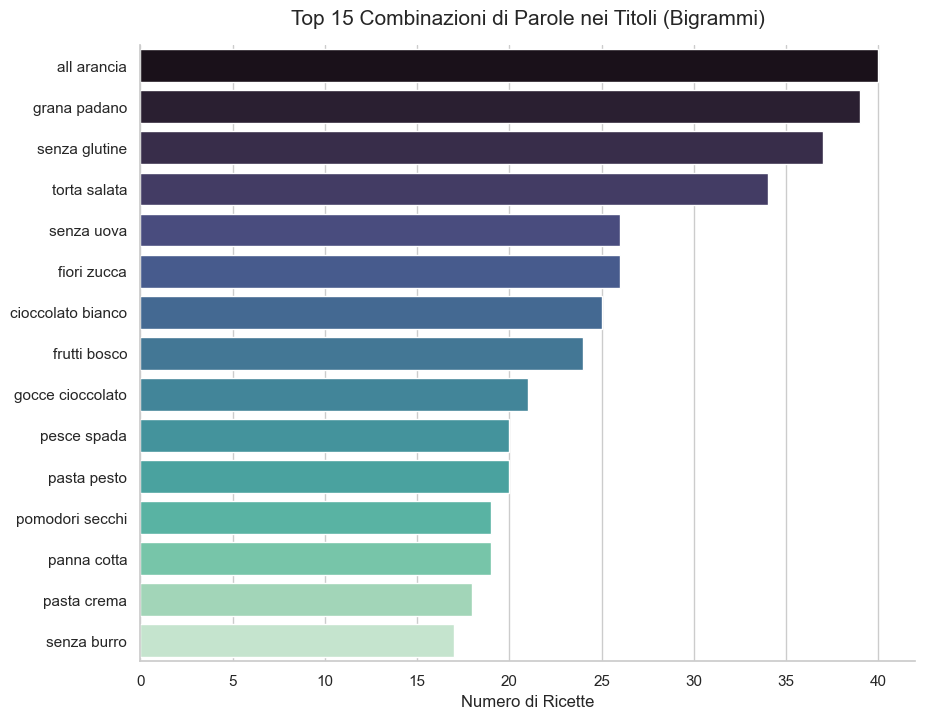

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

# 1. Preparazione: Usiamo CountVectorizer per trovare le coppie di parole (bigrammi)
# Definiamo delle stop words italiane base per pulire i risultati (articoli, preposizioni)
stop_words_it = [
    'di', 'a', 'da', 'in', 'con', 'su', 'per', 'tra', 'fra', 'il', 'lo', 'la', 'i', 'gli', 'le', 
    'un', 'uno', 'una', 'e', 'o', 'al', 'allo', 'alla', 'ai', 'agli', 'alle', 'del', 'dello', 
    'della', 'dei', 'degli', 'delle', 'nel', 'nello', 'nella', 'nei', 'negli', 'nelle', 'sul', 
    'sullo', 'sulla', 'sui', 'sugli', 'sulle', 'l', 'd', 'ricetta', 'base'
]

# Impostiamo il vettorizzatore per cercare coppie di 2 parole (ngram_range=(2,2))
c_vec = CountVectorizer(stop_words=stop_words_it, ngram_range=(2, 2))

# Trasformiamo i titoli
ngrams = c_vec.fit_transform(recipes['Nome'])

# Contiamo la frequenza
count_values = ngrams.toarray().sum(axis=0)
vocab = c_vec.vocabulary_

# Creiamo un DataFrame per il grafico
df_bigram = pd.DataFrame(sorted([(count_values[i], k) for k, i in vocab.items()], reverse=True)).rename(columns={0: 'Frequenza', 1: 'Bigramma'})

# 2. PLOT: Top 15 Bigrammi
plt.figure(figsize=(10, 8))
sns.barplot(x='Frequenza', y='Bigramma', data=df_bigram.head(15), palette='mako')
plt.title('Top 15 Combinazioni di Parole nei Titoli (Bigrammi)', fontsize=15, pad=15)
plt.xlabel('Numero di Ricette')
plt.ylabel('')
sns.despine()
plt.show()

Heatmap delle categorie

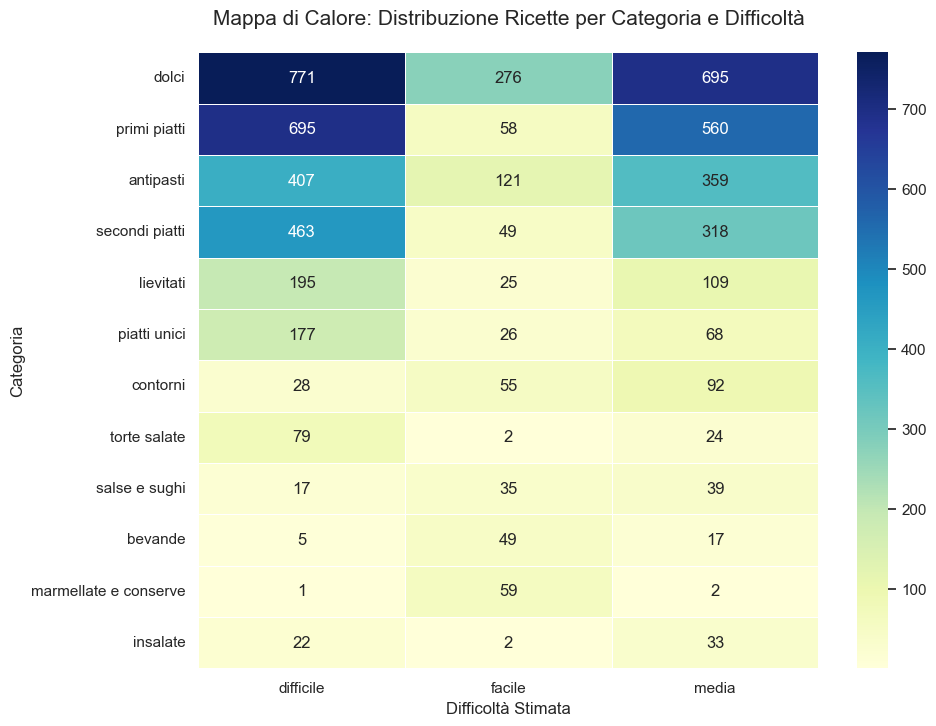

In [29]:
# Creiamo una tabella pivot: Categoria vs Difficoltà
heatmap_data = pd.crosstab(recipes['Categoria'], recipes['difficolta'])

# Ordiniamo per totale per avere le categorie più popolari in alto
heatmap_data['totale'] = heatmap_data.sum(axis=1)
heatmap_data = heatmap_data.sort_values('totale', ascending=False).drop(columns='totale')

# PLOT: Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data, 
    annot=True,      # Scrive i numeri dentro le celle
    fmt="d",         # Formato numeri interi
    cmap="YlGnBu",   # Colore dal giallo al blu scuro
    linewidths=.5    # Linee bianche tra i quadrati
)
plt.title('Mappa di Calore: Distribuzione Ricette per Categoria e Difficoltà', fontsize=15, pad=20)
plt.xlabel('Difficoltà Stimata')
plt.ylabel('Categoria')
plt.show()

Salvataggio del dataset pulito

In [31]:
OUTPUT_PATH = "../../datasets/italian_recipes_clean.csv"

recipes.to_csv(OUTPUT_PATH, index=False)
print("Dataset pulito salvato!")

Dataset pulito salvato!
